In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
import time
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.naive_bayes import GaussianNB

%matplotlib inline
plt.style.use('seaborn-white')

In [49]:
all_data = pd.read_csv(r'C:\Users\queen\Downloads\new_data.csv')
all_data.head()

,ridership_route_code,current_garage,year_month,day_type,on_time_percent,avg_riders,day_count,daily_trip_dist,daily_trip_count,year,month,current_garage_code,day_type_code
0,001,Ross,201701,WEEKDAY,0.6837,1552,22,1158.621,47,2017,1,3,2
1,001,Ross,201701,SAT.,0.6977,970,4,739.695,30,2017,1,3,0
2,001,Ross,201701,SUN.,0.6280,737,5,641.069,26,2017,1,3,1
3,002,Ross,201701,WEEKDAY,0.6978,1020,22,1006.109,54,2017,1,3,2
4,004,Ross,201701,WEEKDAY,0.7438,684,22,283.652,46,2017,1,3,2


In [50]:
#Creates a dummy variable to identify months that occurred during or before the pandemic
all_data.loc[all_data.year_month >= 202001, 'Pandemic'] = 1
all_data.loc[all_data.year_month < 202001, 'Pandemic'] = 0
#Creates an x and y set, were the y variable is average monthly ridership
y = all_data['avg_riders']
x = all_data.drop(columns=['avg_riders'])

print(x.shape,y.shape)

#Splits the data into a training and test set
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   test_size=0.3,
                                                   random_state=0)

(13025, 13) (13025,)


In [52]:
x_train = x_train.drop(columns=['ridership_route_code','day_count','current_garage','day_type'])
x_test = x_test.drop(columns=['ridership_route_code','day_count','current_garage','day_type'])

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
x_train.head()

(9117, 9) (3908, 9)
(9117,) (3908,)


,year_month,on_time_percent,daily_trip_dist,daily_trip_count,year,month,current_garage_code,day_type_code,Pandemic
7479,201904,0.6083,1176.768,48,2019,4,3,2,0.0
6446,201812,0.7959,69.375,23,2018,12,3,2,0.0
4770,201806,0.7715,156.459,25,2018,6,0,0,0.0
3896,201803,0.6278,2068.040,80,2018,3,1,2,0.0
5090,201807,0.6306,719.210,74,2018,7,3,0,0.0


In [ ]:
First we test a linear regression model on the data.

In [80]:
model = LinearRegression()
    
for i in range(1, x_train.shape[1]): 
    sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = i, 
                                direction="forward",
                                scoring='neg_mean_squared_error',
                                cv=10) 
    sfs = sfs.fit(x_train,y_train)
    feature_names = x_train.columns
    print(str(i)+" features selected by forward sequential selection: "+str(feature_names[sfs.get_support()])) 
    X_selected = sfs.transform(x_test) 
    CV_error = np.mean(cross_val_score(model, X_selected, y_test, scoring='neg_mean_squared_error', cv=10)) #calculates CV error by taking the mean cross_val_score
    print("CV error: "+str(CV_error))

1 features selected by forward sequential selection: Index(['daily_trip_count'], dtype='object')
CV error: -1367321.3120749902
2 features selected by forward sequential selection: Index(['daily_trip_count', 'Pandemic'], dtype='object')
CV error: -1032935.4714162055
3 features selected by forward sequential selection: Index(['on_time_percent', 'daily_trip_count', 'Pandemic'], dtype='object')
CV error: -1001324.2584047575
4 features selected by forward sequential selection: Index(['on_time_percent', 'daily_trip_count', 'current_garage_code',
       'Pandemic'],
      dtype='object')
CV error: -978989.2931552834
5 features selected by forward sequential selection: Index(['on_time_percent', 'daily_trip_count', 'current_garage_code',
       'day_type_code', 'Pandemic'],
      dtype='object')
CV error: -966285.3049075773
6 features selected by forward sequential selection: Index(['on_time_percent', 'daily_trip_count', 'year', 'current_garage_code',
       'day_type_code', 'Pandemic'],
      

The linear model with 7 features selected has the lowest test MSE error. Below, we fit a linear model with all features to compare to the model with only 7 features.

In [84]:
#Creates a linear regression object and fits it to the training data
lm = LinearRegression().fit(x_train,y_train)

y_train_pred = lm.predict(x_train)
y_test_pred = lm.predict(x_test)

print('Train R2 value = ',lm.score(x_train,y_train))
print('Test R2 value = ',lm.score(x_test,y_test))

print('Train MSE = ',mean_squared_error(y_train,y_train_pred))   
print('Test MSE = ',mean_squared_error(y_test,y_test_pred))
#Prints coefficients found by the model
coefficients = pd.DataFrame(lm.coef_)
coefficients['Features'] = feature_names
coefficients

Train R2 value =  0.5160348183706605
Test R2 value =  0.5058872651898392
Train MSE =  942973.1282756843
Test MSE =  954702.9405170439


,0,Features
0,0.440489,year_month
1,-2443.761888,on_time_percent
2,-0.051911,daily_trip_dist
3,19.123003,daily_trip_count
4,0.023615,year
5,-1.920993,month
6,94.751790,current_garage_code
7,134.289462,day_type_code
8,-1436.407521,Pandemic


The model with all features selected is the best linear model because the test MSE is even lower. 

From the coefficients produced by the model, we can interpret the average relationships between each feature and average monthly ridership. For example, increasing year_month one month into the future increases average ridership by just 0.44. Riding on a weekday as opposed to a Sunday increases average ridership by about 134. Oddly, increasing on time percentage by 1 decreases average ridership by about 2444. 

Since the linear regression only had a test R squared of about 0.51, other models may do better at predicting average ridership. I test a decision tree model below to see if its predictions will improve.

In [55]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0).fit(x_train,y_train)

y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)

print('Train R2 value = ',dt.score(x_train,y_train))
print('Test R2 value = ',dt.score(x_test,y_test))

print('Train MSE = ',mean_squared_error(y_train,y_train_pred))  
print('Test MSE = ',mean_squared_error(y_test,y_test_pred))

Train R2 value =  1.0
Test R2 value =  0.962121784471742
Train MSE =  0.0
Test MSE =  73186.62563971341


These test R squared and MSE values are much better. To see if we can improve the model further, we use grid search cross validation to tune the decision tree model.

In [63]:
from sklearn.model_selection import GridSearchCV
dt_grid = {'min_samples_leaf': [1,2,3,5,8,10,15],'max_features': ['auto','sqrt','log2'], 'max_depth': [2,3,5,8,10,15,20,25,30]}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0), dt_grid, cv=10, return_train_score=True)
best_dt_model = grid_search.fit(x_train, y_train)
#calculates and prints the best parameter for each of the three parameters that were tuned above
best_min_samples = best_dt_model.best_estimator_.get_params()['min_samples_leaf']
best_max_feat = best_dt_model.best_estimator_.get_params()['max_features']
best_max_depth = best_dt_model.best_estimator_.get_params()['max_depth']
print("Best minimum samples per leaf node: "+str(best_min_samples))
print("Best maximum number of features: "+str(best_max_feat))
print("Best maximum depth: "+str(best_max_depth))
print("Test set score: {:.2f}".format(grid_search.score(x_test,y_test)))

Best minimum samples per leaf node: 3
Best maximum number of features: auto
Best maximum depth: 20
Test set score: 0.96


In [66]:
#Refits decision tree model with best parameters
dt_tuned = DecisionTreeRegressor(min_samples_leaf=best_min_samples, max_features=best_max_feat, max_depth=best_max_depth, random_state=0)
dt_tuned.fit(x_train, y_train)
y_train_pred = dt_tuned.predict(x_train)
y_test_pred = dt_tuned.predict(x_test)

print('Train R2 value = ',dt_tuned.score(x_train,y_train))
print('Test R2 value = ',dt_tuned.score(x_test,y_test))

print('Train MSE = ',mean_squared_error(y_train,y_train_pred)) 
print('Test MSE = ',mean_squared_error(y_test,y_test_pred))

Train R2 value =  0.9918033520568886
Test R2 value =  0.9620777039914716
Train MSE =  15970.609138179443
Test MSE =  73271.79600908209


The tuned model above did not perform better than the original model. We make another attempt to improve the model by leaving out one of the parameters chosen by the grid search.

In [69]:
#Refits decision tree model using all of the best parameters found by grid search except for max depth
dt_tuned = DecisionTreeRegressor(min_samples_leaf=best_min_samples, max_features=best_max_feat, random_state=0)
dt_tuned.fit(x_train, y_train)
y_train_pred = dt_tuned.predict(x_train)
y_test_pred = dt_tuned.predict(x_test)

print('Train R2 value = ',dt_tuned.score(x_train,y_train))
print('Test R2 value = ',dt_tuned.score(x_test,y_test))

print('Train MSE = ',mean_squared_error(y_train,y_train_pred)) 
print('Test MSE = ',mean_squared_error(y_test,y_test_pred))

Train R2 value =  0.9918042058363794
Test R2 value =  0.9622818545352622
Train MSE =  15968.9456071076
Test MSE =  72877.34528815535


This did improve the test R squared and test MSE. To see if another model will do better, we test a random forest regressor model below.

In [70]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0).fit(x_train,y_train)

y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

print('Train R2 value = ',rf.score(x_train,y_train))
print('Test R2 value = ',rf.score(x_test,y_test))

print('Train MSE = ',mean_squared_error(y_train,y_train_pred))   
print('Test MSE = ',mean_squared_error(y_test,y_test_pred))

Train R2 value =  0.9969283318904071
Test R2 value =  0.9786257266177766
Train MSE =  5984.935686026106
Test MSE =  41298.43295227738


This random forest model had a slightly better test R2 and test MSE value than the decision tree models, so now we used grid search cross validation to tune the random forest model and see if it improves.

In [72]:
rf_grid = {'n_estimators': [10, 20, 50, 100, 150, 200], 'min_samples_leaf': [1,2,3,5],'max_features': ['auto','sqrt','log2'], 'max_depth': [5,8,10,15,20]}
grid_search = GridSearchCV(RandomForestRegressor(), rf_grid, cv=10, return_train_score=True)
best_rf_model = grid_search.fit(x_train, y_train)
#calculates and prints the best parameter for each of the four parameters that were tuned above
best_n_est = best_rf_model.best_estimator_.get_params()['n_estimators']
best_min_samples = best_rf_model.best_estimator_.get_params()['min_samples_leaf']
best_max_feat = best_rf_model.best_estimator_.get_params()['max_features']
best_max_depth = best_rf_model.best_estimator_.get_params()['max_depth']
print("Best number of trees/estimators: "+str(best_n_est))
print("Best minimum samples per leaf node: "+str(best_min_samples))
print("Best maximum number of features: "+str(best_max_feat))
print("Best maximum depth: "+str(best_max_depth))
print("Test set score: {:.2f}".format(grid_search.score(x_test,y_test)))

Best number of trees/estimators: 200
Best minimum samples per leaf node: 1
Best maximum number of features: auto
Best maximum depth: 20
Test set score: 0.98


In [73]:
#Refits random forest model with best parameters
rf_tuned = RandomForestRegressor(n_estimators=best_n_est, min_samples_leaf=best_min_samples, max_features=best_max_feat, random_state=0)
rf_tuned.fit(x_train, y_train)
y_train_pred = rf_tuned.predict(x_train)
y_test_pred = rf_tuned.predict(x_test)

print('Train R2 value = ',rf_tuned.score(x_train,y_train))
print('Test R2 value = ',rf_tuned.score(x_test,y_test))

print('Train MSE = ',mean_squared_error(y_train,y_train_pred)) 
print('Test MSE = ',mean_squared_error(y_test,y_test_pred))

Train R2 value =  0.997016272350537
Test R2 value =  0.9787515558572513
Train MSE =  5813.589700946035
Test MSE =  41055.31121817426


This refitted random forests model has the best test R squared and test MSE values of any model we have tested so far. Thus, we use this model as our best model. Below, we determine and plot the feature importances for this model.

Text(0.5, 0, 'Features')

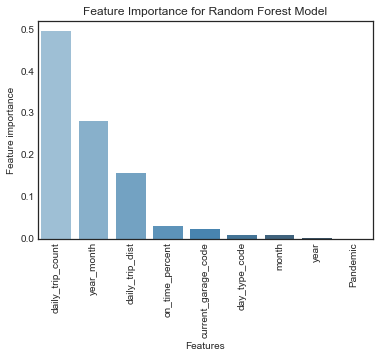

In [75]:
#Sreates a dataframe with feature importances
forest_importances = pd.DataFrame({'features': x_train.columns, 'importances': rf_tuned.feature_importances_})
#uses this dataframe to create a bar plot of the feature importances
sns.barplot(x="features",y="importances" ,data=forest_importances, 
            order=forest_importances.sort_values('importances',ascending = False).features, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Feature Importance for Random Forest Model")
plt.ylabel("Feature importance")
plt.xlabel("Features")

The most important features in predicting average monthly ridership are the daily trip count, month and year, and the daily trip distance. 